<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset




Models:
<br>

| Model | Backbone | Image Size | Parameters| GFLOPs | Weight Size
| --- | --- | --- | --- | --- | ---
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 | 13.4MB
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 | 136MB
| RetinaNet | ResNet-50 FPN | 800x800 | 34M | 303.5 | 130MB
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9 | 74.3MB
| Faster R-CNN |  MobileNetV3-Large FPN  | 320x320 | 19.4M | 1.4 | 74.2MB 
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 240.4 | 160MB
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 259.9 | 170MB
| YOLOv5n |  Custom CSPDarknet | 640x640 | 1.9M | 4.5 | 3.8MB
| YOLOv5s |  Custom CSPDarknet | 640x640 | 7.2M | 16.5 | 14MB
| YOLOv5m |  Custom CSPDarknet | 640x640 | 21.2M | 49 | 40.5MB
| YOLOv5l |  Custom CSPDarknet |640x640 | 47M | 115.5 | 89.2MB
| YOLOv4 |  CSPDarknet53 | 608x608 | 64.4M | 128.9 | 258MB
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 | 17MB
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 | 119MB
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 | 121MB

**Note: GPU Runtime needed (hosted or local)**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=1, workers=2*

In [1]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Initialization

In [2]:
# Parameters

num_workers = 2  #  Data loader workers
batch_size = 1  # Data loader batch size


# Directories

import os
root_dir = os.getcwd()  # Root dir of project
dataset_dir = os.path.join(root_dir,'dataset_COCO17')

### Get requirements
*Note: Takes about 5 minutes. Restart runtime after installation if a problem arises.*

In [3]:
# Clone asset files
!cd {root_dir}
!git clone https://github.com/joangog/object-detection-assets
!mv -n {os.path.join(root_dir,'object-detection-assets','scripts')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','requirements.txt')} ./
!rm -rf {os.path.join(root_dir,'object-detection-assets')}


Cloning into 'object-detection-assets'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 223 (delta 101), reused 171 (delta 52), pack-reused 0
Receiving objects: 100% (223/223), 40.31 KiB | 408.00 KiB/s, done.
Resolving deltas: 100% (101/101), done.


In [ ]:
# Install packages
!cd {root_dir}
!pip install -r requirements.txt
!pip install --upgrade numpy

In [ ]:
# Install YOLOv5
!cd {root_dir}
!git clone https://github.com/joangog/yolov5
!pip install -r {os.path.join(root_dir,'yolov5','requirements.txt')}

In [ ]:
# Install YOLOv4
!cd {root_dir}
!git clone https://github.com/joangog/yolov4
# !pip install -r {os.path.join(root_dir,'yolov4','requirements.txt')}


In [ ]:
# Install YOLOv3
!cd {root_dir}
!git clone https://github.com/ultralytics/yolov3
!pip install -r {os.path.join(root_dir,'yolov3','requirements.txt')}

### Import packages

In [8]:
from google.colab import files
from google.colab import drive

import gdown

import os, sys
import math
import time
import copy
import re

import numpy as np
import pandas as pd
import json
import PIL
import cv2
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

sys.path.append('yolov4')
from yolov4.tool.darknet2pytorch import Darknet as yolov4_Darknet
from yolov4.tool.utils import post_processing as yolov4_post_processing

### (Optional) Connect to GDrive for storage access
*Note: Not possible with local runtime*

In [9]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Download COCO 2017 validation dataset

In [10]:
!cd {root_dir}
!mkdir -p dataset_COCO17

In [ ]:
# Download images
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -q -n val2017.zip -d {dataset_dir}

!cd {dataset_dir}

# Download annotations
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q -n annotations_trainval2017.zip -d {dataset_dir}
!cp {os.path.join(dataset_dir,'annotations','instances_val2017.json')} {os.path.join(dataset_dir,'val2017')}

### Load COCO 2017 validation dataset

In [ ]:
img_dir = os.path.join(dataset_dir,'val2017')
ann_file = 'instances_val2017.json'  # annotations
ann_path = os.path.join(img_dir,ann_file)

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_path, transforms = transforms)

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

### (Optional) Get dataset resolution information

In [13]:
img_ids = dataset.coco.getImgIds()
img_x_arr = []
img_y_arr = []

for img_id in img_ids:
  img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
  img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
  img_shape = img_tensor.shape
  img_x_arr.append(img_shape[1])
  img_y_arr.append(img_shape[2])

img_x_median = np.mean(img_x_arr)
img_y_median = np.mean(img_y_arr)

img_x_max = np.max(img_x_arr)
img_y_max = np.max(img_y_arr)

img_x_min = np.min(img_x_arr)
img_y_min = np.min(img_y_arr)

print(f'Median resolution: {img_x_median,img_y_median}')
print(f'Maximum resolution: {img_x_max,img_y_max}')
print(f'Minimum resolution: {img_x_min,img_y_min}')

Median resolution: (483.543, 573.7548)
Maximum resolution: (640, 640)
Minimum resolution: (145, 200)


### Load pre-trained model

In [14]:
!cd {root_dir}

# Empty cache to properly calculate max memory
torch.cuda.empty_cache() 

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5s' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'RetinaNet ResNet-50 FPN', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Faster R-CNN MobileNetV3-Large 320 FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5n', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv4', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note 1: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

# @markdown *Note 2: R-CNN GFLOPs may vary because the model performs input dependent computations and therefore needs to be averaged*


if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'RetinaNet ResNet-50 FPN':
  model_id = 'retinanet_resnet50_fpn'
  model = M.retinanet_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Faster R-CNN MobileNetV3-Large 320 FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_320_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)
  model_img_size = (3,320,320) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'YOLOv5n':
  model_id = 'yolov5n'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5n', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv4':
  model_id = 'yolov4'
  yolov4_cfg = os.path.join(root_dir,'yolov4/cfg/yolov4.cfg')
  yolov4_weights = os.path.join(root_dir,'yolov4.weights')
  model = yolov4_Darknet(yolov4_cfg)
  if not os.path.exists(yolov4_weights):
    !gdown --id '1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT' # Download weights
  model.load_weights(yolov4_weights)
  model_img_size = (3,model.height,model.width)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp', force_reload=True)
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')

# Get the average of model macs
model_macs_arr = []
n = 10  # Select number of samples (e.g. 10)
for i in range(0,n):
  temp_model = copy.deepcopy(model)
  model_macs, _ = get_model_complexity_info(temp_model, model_img_size, as_strings=False, print_per_layer_stat=False, verbose=False)
  model_macs_arr.append(model_macs)
model_macs = sum(model_macs_arr)/n
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: torch>=1.7.0 not found and is required by YOLOv5, attempting auto-update...

requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...

requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...

requirements: 4 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-3-13 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5s
	- Parameters: 7.2M
	- GFLOPs: 16.5


### (Optional) Test model with image sample
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


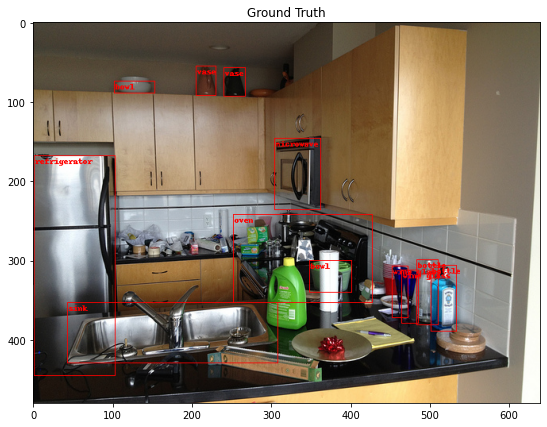

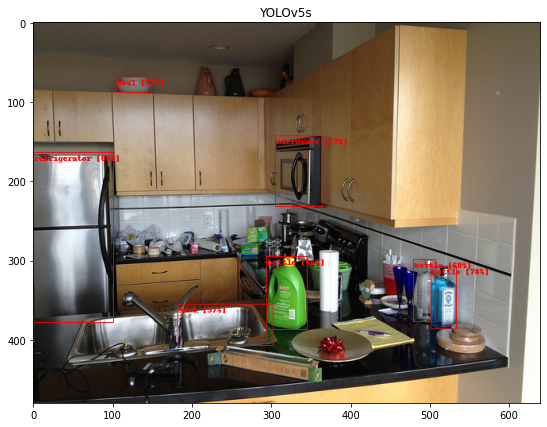

In [15]:
%matplotlib inline

# Parameters
img_id = 7574
bbox_color = 'red'
th = 0.5  # Threshold for confidence score of predicted bboxes to show

# Get appropriate device for model
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
model.to(device)

# Get image sample
img_file = os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name'])
img = PIL.Image.open(img_file)
img_cv = cv2.imread(img_file)

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Format image
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor.float(),255).to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Get ground truth bboxes
true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels, colors=[bbox_color for bbox in true_bboxes])
plt.figure(figsize = (25,7))
plt.title('Ground Truth') # plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLOv3' in model_name or 'YOLOv5' in model_name:
    pred = model([img])
  elif 'YOLOv4' in model_name:
    img_yolov4 = torch.from_numpy(cv2.cvtColor(cv2.resize(img_cv, (model.width, model.height)), cv2.COLOR_BGR2RGB).transpose(2, 0, 1)).float().div(255.0).unsqueeze(0).to(device)
    output = model(img_yolov4)
    pred = yolov4_post_processing(img, 0, 0.6, output)
  else:    
    pred = model([img_torchvision])

# Get predictions
pred_bboxes = []
pred_masks = []
pred_label_ids = []
pred_labels = []
# For YOLO v3 and v5 models
if 'YOLOv3' in model_name or 'YOLOv5' in model_name:
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)
# For YOLOv4 model
elif 'YOLOv4' in model_name:
  for bbox in pred[0]:
    if len(bbox) != 0:
      conf = bbox[4]
      if conf > th:  # Show only bboxes with high confidence score
        img_height = img_cv.shape[0]
        img_width = img_cv.shape[1]
        bbox_x1 = int(bbox[0] * img_width)
        bbox_y1 = int(bbox[1] * img_height)
        bbox_x2 = int(bbox[2] * img_width)
        bbox_y2 = int(bbox[3] * img_height)
        pred_bboxes.append(torch.as_tensor([bbox_x1,bbox_y1,bbox_x2,bbox_y2]))
        label_id = labels_inv[label_names[int(bbox[6])]]  # Convert YOLO label id to COCO label id
        pred_label_ids.append(label_id)  
        pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      if 'Mask' in model_name:
        mask = pred[0]['masks'][i].squeeze()
        pred_masks.append(mask)
      label_id = pred[0]['labels'][i].item()
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)
    if 'Mask' in model_name:
      pred_masks = torch.stack(pred_masks)
      pred_masks = pred_masks > th  # Convert to boolean masks

# Draw Predictions
if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels, colors=[bbox_color for bbox in pred_bboxes])
  if 'Mask' in model_name:
    pred_img_masks = U.draw_segmentation_masks(img_tensor, pred_masks, alpha=0.8)
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
  if 'Mask' in model_name:
    pred_img_masks = img_tensor

# Plot Predictions
plt.figure(figsize = (25,7))
plt.title(f'{model_name}') # plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))
if 'Mask' in model_name:
    plt.figure(figsize = (25,7))
    plt.title(f'{model_name}') # plt.title(f'Predicted Detection (thresh={th})')
    plot = plt.imshow(F.to_pil_image(pred_img_masks))

### Evaluate model
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*

*Note 2: To get accurate maximum GPU memory usage logging, restart runtime when choosing a different model.*

In [16]:
# Clear cache for accurate maximum GPU memory usage logging
torch.cuda.empty_cache() 

# Get appropriate device for model
device = torch.device('cuda')
model.to(device)
print(f'Model: {model_name + ( " ("  + str(model_img_size[1]) + ") " if "yolo" in model_id else "")}')

# Evaluate model
evaluator, fps, max_mem, outputs = SE.evaluate(model, data_loader, device, img_size=model_img_size[1])

print(f'\nFPS: {fps}\n')

Model: YOLOv5s (640) 
Test:  [   0/5000]  eta: 0:20:53  model_time: 0.0485 (0.0485)  evaluator_time: 0.0351 (0.0351)  time: 0.2508  data: 0.1531  max mem: 293
Test:  [ 100/5000]  eta: 0:07:52  model_time: 0.0591 (0.0465)  evaluator_time: 0.0271 (0.0178)  time: 0.1417  data: 0.0120  max mem: 293
Test:  [ 200/5000]  eta: 0:09:19  model_time: 0.0812 (0.0561)  evaluator_time: 0.0244 (0.0219)  time: 0.1633  data: 0.0126  max mem: 293
Test:  [ 300/5000]  eta: 0:08:09  model_time: 0.0333 (0.0518)  evaluator_time: 0.0053 (0.0184)  time: 0.0547  data: 0.0026  max mem: 293
Test:  [ 400/5000]  eta: 0:07:00  model_time: 0.0330 (0.0475)  evaluator_time: 0.0047 (0.0153)  time: 0.0507  data: 0.0026  max mem: 293
Test:  [ 500/5000]  eta: 0:06:16  model_time: 0.0333 (0.0448)  evaluator_time: 0.0057 (0.0134)  time: 0.0547  data: 0.0022  max mem: 293
Test:  [ 600/5000]  eta: 0:05:46  model_time: 0.0346 (0.0431)  evaluator_time: 0.0054 (0.0123)  time: 0.0552  data: 0.0023  max mem: 293
Test:  [ 700/5000] 

### Save metric results

In [ ]:
cols = ['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_img_size_arr = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
max_mem_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_name for i in range(0,12)]
  model_img_size_arr += [model_img_size[1] for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  max_mem_arr += [max_mem for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

results = pd.DataFrame(np.column_stack([model, model_img_size_arr, model_params_arr, model_gflops_arr, fps_arr, max_mem_arr, iou_type, metric, iou, area, max_dets, score]))
results.columns = cols

In [ ]:
# Save to file

results_dir = root_dir

gpu = torch.cuda.get_device_name(0).lower()
for pattern in [' ', 'tesla', 'geforce', 'nvidia']:  # Keep only short gpu name
  gpu = gpu.replace(pattern,'')

results_file = f'COCO17_{gpu}_{model_id + ("_" + str(model_img_size[1]) if "yolo" in model_id else "")}_metrics.csv'
results_path = os.path.join(results_dir, results_file)

if os.path.exists(results_path):
      os.remove(results_path)
results.to_csv(results_path)

### (Optional) Save results to GDrive

In [ ]:
# Save to GDrive
gdrive_results_dir = '/content/drive/MyDrive/object-detection-results'
!mkdir {gdrive_results_dir}
!mkdir {os.path.join(gdrive_results_dir,'COCO17')}
gdrive_results_path = os.path.join(gdrive_results_dir,'COCO17',results_file)
if os.path.exists(gdrive_results_path):
  os.remove(gdrive_results_path)
with open(gdrive_results_path, 'w') as outfile: 
  results.to_csv(outfile)